# Start-to-Finish Example: Numerical Solution of the wave Equation, in Cartesian Coordinates

## Author: Zach Etienne

## This notebook solves the wave equation in Cartesian coordinates, using the [Method of Lines](Tutorial-Method_of_Lines-C_Code_Generation.ipynb), and validates the solution against the exact one, confirming its expected convergence behavior.

**Notebook Status:** <font color='green'><b>Validated</b></font>

**Validation Notes:** This module has been validated to converge at the expected order to the exact solution (see [plot](#Step-3:-Code-validation:-Verify-that-relative-error-in-numerical-solution-converges-to-zero-at-the-expected-order) at bottom).

### NRPy Source Code for this module:
* `nrpy/equations/wave_equation/WaveEquation_RHSs.py` generates the right-hand side for the wave equation in Cartesian coordinates.
* `nrpy/equations/wave_equation/WaveEquation_Solutions_InitialData.py` generates analytic solutions and initial data for the wave equation (plane-wave or spherical Gaussian) in Cartesian coordinates.

## Introduction

As outlined in the [previous tutorial notebook](wave_equation_and_c_codegen.ipynb), we first use NRPy to generate initial data for the wave equation, and then we use it to generate the right-hand side (RHS) expressions for Method-of-Lines time integration based on the explicit 4th-order Runge-Kutta scheme (RK4).

The overall algorithm is:

1. Allocate memory for gridfunctions, including temporary storage for the Method-of-Lines (MoL) time integration.
    * [**NRPy tutorial notebook on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb)
2. Set gridfunction values to initial data (here, a monochromatic plane wave or spherical Gaussian exact solution).
3. Integrate the initial data forward in time using MoL + RK4.
    1. At the start of each iteration in time, output the difference between the numerical and exact solution at the grid center.
    2. At each RK substep:
        1. Evaluate wave RHS expressions.
        2. Apply boundary conditions using quadratic extrapolation on all 6 faces of the cube.
4. Repeat the above steps at multiple resolutions to confirm the expected 4th-order convergence of the solution.

# Table of Contents

This notebook is organized as follows.

1. [Step 1](#Step-1:-Set-up-core-functions-and-parameters-for-solving-wave-equation): Set up core functions and parameters for solving wave equation
    1. [Step 1.a](#Step-1.a:-apply_bcs():-outer-boundary-condition-driver-function) `apply_bcs()`: outer boundary condition driver function
    2. [Step 1.b](#Step-1.b:-Generate-Method-of-Lines-timestepping-code) Generate Method of Lines timestepping code
    3. [Step 1.c](#Step-1.c:-Output-C-codes-needed-for-declaring-and-setting-CodeParameters;-also-set-free-parameters-and-parfile) Output C codes needed for declaring and setting CodeParameters; also set free parameters and parfile
2. [Step 2](#Step-2:-Main-C-code-and-project-structure): Main C code and project structure
3. [Step 3](#Step-3:-Code-validation:-Verify-that-relative-error-in-numerical-solution-converges-to-zero-at-the-expected-order): Code validation: Verify that relative error in numerical solution converges to zero at the expected order
4. [Step 4](#Step-4:-Output-this-notebook-to-LaTeX-formatted-PDF-file): Output this notebook to $\LaTeX$-formatted PDF file

# Step 1: Set up core functions and parameters for solving wave equation
### [Back to [top](#Table-of-Contents)]

In this step we:

* Initialize core NRPy modules (`nrpy.params`, `nrpy.c_codegen`, `nrpy.c_function`, `nrpy.grid`).
* Choose code-generation-time parameters: finite-difference order, domain size, timestepper, and SIMD options.
* Register C functions via `nrpy.c_function.register_CFunction` to:
  * Set up numerical grids and time steps.
  * Evaluate the exact solution at a single Cartesian point.
  * Initialize data on the grid from the exact solution at $t = 0$.
  * Evaluate the RHSs of the wave equation.
  * Apply outer boundary conditions.
  * Output diagnostics (relative error at the grid center as a function of time).

We use the BHaH infrastructure (`Infrastructure = "BHaH"`), which provides:

* `commondata_struct` for simulation-wide parameters (for example CFL factor, $t_{\text{final}}$, convergence factor).
* `griddata_struct` for per-grid parameters and coordinate arrays.
* Convenience helpers for loops over grid points and Method-of-Lines timestepping.

In [1]:
# Step 1: Initialize core NRPy modules and code-generation-time parameters

import os
import shutil

import nrpy.c_codegen as ccg          # NRPy: core C code output
import nrpy.c_function as cfc         # NRPy: C function objects and registry
import nrpy.grid as gri               # NRPy: gridfunctions and grid parameters
import nrpy.indexedexp as ixp         # NRPy: indexed expressions (tensors)
import nrpy.params as par             # NRPy: parameter interface

from nrpy.equations.wave_equation.WaveEquation_RHSs import WaveEquation_RHSs
from nrpy.equations.wave_equation.WaveEquation_Solutions_InitialData import (
    WaveEquation_solution_Cartesian,
)
from nrpy.helpers.generic import copy_files
from nrpy.infrastructures import BHaH

# Specify the BlackHoles@Home infrastructure in NRPy
par.set_parval_from_str("Infrastructure", "BHaH")

# Code-generation-time parameters
project_name = "wave_equation_cartesian"
fp_type = "double"

# Choose analytic solution / initial data type:
#   "PlaneWave" or "SphericalGaussian"
WaveType = "PlaneWave"
default_sigma = 2.0  # used for Gaussian initial data

MoL_method = "RK4"
fd_order = 4

# Domain size: x, y, z in [-domain_size, +domain_size]
domain_size = 10.0

# Final time: choose so that signals from the outer boundary have not reached the origin
t_final = 0.8 * domain_size

enable_simd = True
enable_KreissOliger_dissipation = False

project_dir = os.path.join("project", project_name)

# Clean project directory if it exists
shutil.rmtree(project_dir, ignore_errors=True)

# Set global parameters for finite-difference order and floating-point type
par.set_parval_from_str("fd_order", fd_order)
par.set_parval_from_str("fp_type", fp_type)

# Register core CodeParameters for the grid
for i in range(3):
    _ = par.CodeParameter("int", __name__, f"Nxx{i}", 48)
    _ = par.CodeParameter("REAL", __name__, f"xxmin{i}", -domain_size)
    _ = par.CodeParameter("REAL", __name__, f"xxmax{i}", +domain_size)
    # Parameters whose defaults will be overwritten in numerical_grids_and_timestep():
    _ = par.CodeParameter(
        "int",
        __name__,
        f"Nxx_plus_2NGHOSTS{i}",
        -1,
        add_to_parfile=False,
        add_to_set_CodeParameters_h=True,
    )
    _ = par.CodeParameter(
        "REAL",
        __name__,
        f"invdxx{i}",
        -0.1,
        add_to_parfile=False,
        add_to_set_CodeParameters_h=True,
    )
    _ = par.CodeParameter(
        "REAL",
        __name__,
        f"dxx{i}",
        -0.1,
        add_to_parfile=False,
        add_to_set_CodeParameters_h=True,
    )

# Convergence factor for resolution studies (for example 1.0, 4/3, 2.0)
_ = par.CodeParameter("REAL", __name__, "convergence_factor", 1.0, commondata=True)

## Step 1.a: apply_bcs(): outer boundary condition driver function
### [Back to [top](#Table-of-Contents)]

When solving the wave equation on a 3D Cartesian grid cube (a rectangular prism), we proceed at each time step as follows:

1. Evaluate the RHSs of the evolution equations (which involve spatial derivatives).
2. Advance the data in time using the Method of Lines (here, 4th-order RK).
3. Apply boundary conditions to fill ghost zones.

Finite-difference derivatives are defined only in the grid interior, as they require neighboring points. For example, a standard 4th-order centered finite difference derivative in one spatial dimension uses a stencil that extends two points to the left and right. To maintain a full interior on the next time slice, we must fill ghost zones at the outer boundary.

Here we apply **quadratic extrapolation** to fill all six faces of the cube. The `FACE_UPDATE` macro:

* Updates a given face using three interior layers to construct a quadratic polynomial.
* Fills one layer of ghost cells at a time, moving outward.

The algorithm for each ghost-zone layer:

1. Update the lower $x$ face (interior portion).
2. Update the upper $x$ face.
3. Update the lower $y$ face (including updated $x$ faces).
4. Update the upper $y$ face.
5. Update the lower $z$ face (including updated $x$ and $y$ faces).
6. Update the upper $z$ face.

This ordering ensures that all ghost cells are filled consistently.

In [2]:
def register_CFunction_apply_bcs() -> None:
    """
    Register a C function to apply (quadratic extrapolation) spatial boundary
    conditions to the wave gridfunctions.
    """
    includes = ["BHaH_defines.h"]
    desc = (
        "Apply (quadratic extrapolation) spatial boundary conditions to the "
        "wave gridfunctions.\n"
        "BCs are applied to all six boundary faces of the cube, filling the "
        "innermost ghost zone first and then moving outward."
    )
    cfunc_type = "void"
    name = "apply_bcs"
    params = (
        "const commondata_struct *restrict commondata, "
        "const params_struct *restrict params, REAL *restrict gfs"
    )
    prefunc = r"""
// Declare boundary condition FACE_UPDATE macro,
//          which updates a single face of the 3D grid cube
//          using quadratic polynomial extrapolation.
const int MAXFACE = -1;
const int NUL     = +0;
const int MINFACE = +1;
#define FACE_UPDATE(which_gf, i0min,i0max, i1min,i1max, i2min,i2max, FACEX0,FACEX1,FACEX2) \
  for(int i2=i2min;i2<i2max;i2++) for(int i1=i1min;i1<i1max;i1++) for(int i0=i0min;i0<i0max;i0++) { \
        gfs[IDX4(which_gf,i0,i1,i2)] =                                  \
          +3.0*gfs[IDX4(which_gf,i0+1*FACEX0,i1+1*FACEX1,i2+1*FACEX2)]  \
          -3.0*gfs[IDX4(which_gf,i0+2*FACEX0,i1+2*FACEX1,i2+2*FACEX2)]  \
          +1.0*gfs[IDX4(which_gf,i0+3*FACEX0,i1+3*FACEX1,i2+3*FACEX2)]; \
      }
"""
    body = r"""
#pragma omp parallel for
    for(int which_gf=0;which_gf<NUM_EVOL_GFS;which_gf++) {
#include "set_CodeParameters.h"
      int imin[3] = { NGHOSTS, NGHOSTS, NGHOSTS };
      int imax[3] = { Nxx_plus_2NGHOSTS0-NGHOSTS, Nxx_plus_2NGHOSTS1-NGHOSTS, Nxx_plus_2NGHOSTS2-NGHOSTS };
      for(int which_gz = 0; which_gz < NGHOSTS; which_gz++) {
        // After updating each face, adjust imin[] and imax[]
        //   to reflect the newly-updated face extents.
        FACE_UPDATE(which_gf, imin[0]-1,imin[0], imin[1],imax[1], imin[2],imax[2], MINFACE,NUL,NUL); imin[0]--;
        FACE_UPDATE(which_gf, imax[0],imax[0]+1, imin[1],imax[1], imin[2],imax[2], MAXFACE,NUL,NUL); imax[0]++;

        FACE_UPDATE(which_gf, imin[0],imax[0], imin[1]-1,imin[1], imin[2],imax[2], NUL,MINFACE,NUL); imin[1]--;
        FACE_UPDATE(which_gf, imin[0],imax[0], imax[1],imax[1]+1, imin[2],imax[2], NUL,MAXFACE,NUL); imax[1]++;

        FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imin[2]-1,imin[2], NUL,NUL,MINFACE); imin[2]--;
        FACE_UPDATE(which_gf, imin[0],imax[0], imin[1],imax[1], imax[2],imax[2]+1, NUL,NUL,MAXFACE); imax[2]++;
    }
  }
"""
    cfc.register_CFunction(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        include_CodeParameters_h=False,
        body=body,
    )

## Step 1.b: Generate Method of Lines timestepping code
### [Back to [top](#Table-of-Contents)]

The Method of Lines (MoL) algorithm advances the evolved gridfunctions in time:

1. For each Runge-Kutta substep:
   1. Evaluate RHSs at all interior points, given current gridfunction values.
   2. Apply spatial boundary conditions to fill ghost zones.
2. Combine substeps to update to the next full time level.

NRPy's BHaH infrastructure provides:

* A MoL driver that manages RK substeps and time updates.
* A simple loop builder for iterating over grid interiors and all points.

Here we:

* Define C functions:
  * `rhs_eval()`: evaluate wave equation RHSs.
  * `initial_data()`: set initial data from the exact solution at $t = 0$.
  * `numerical_grids_and_timestep()`: set up grid resolution, coordinates, and timestep.
  * `diagnostics()`: compute and output relative error at the grid center.
  * `exact_solution_single_Cartesian_point()`: analytic solution at one point.
* Tie these into MoL via a call to `BHaH.MoLtimestepping.register_all.register_CFunctions`, specifying:
  * How to compute RHSs.
  * How to apply boundary conditions after each RHS evaluation.

In [3]:
def register_CFunction_numerical_grids_and_timestep_setup() -> None:
    """
    Register a C function to set up numerical grids and time steps.
    """
    includes = ["BHaH_defines.h"]
    desc = r"Set up cell-centered Cartesian grids."
    cfunc_type = "void"
    name = "numerical_grids_and_timestep"
    params = (
        "commondata_struct *restrict commondata, "
        "griddata_struct *restrict griddata, bool calling_for_first_time"
    )
    body = r"""
  commondata->dt = 1e30;
  for (int grid = 0; grid < commondata->NUMGRIDS; grid++) {
    params_struct *restrict params = &griddata[grid].params;
    const REAL convergence_factor = commondata->convergence_factor;
    const REAL xxmin0 = params->xxmin0;
    const REAL xxmin1 = params->xxmin1;
    const REAL xxmin2 = params->xxmin2;
    const REAL xxmax0 = params->xxmax0;
    const REAL xxmax1 = params->xxmax1;
    const REAL xxmax2 = params->xxmax2;

    params->Nxx0 *= convergence_factor;
    params->Nxx1 *= convergence_factor;
    params->Nxx2 *= convergence_factor;

    params->Nxx_plus_2NGHOSTS0 = params->Nxx0 + 2 * NGHOSTS;
    params->Nxx_plus_2NGHOSTS1 = params->Nxx1 + 2 * NGHOSTS;
    params->Nxx_plus_2NGHOSTS2 = params->Nxx2 + 2 * NGHOSTS;

    params->dxx0 = (xxmax0 - xxmin0) / ((REAL)params->Nxx0);
    params->dxx1 = (xxmax1 - xxmin1) / ((REAL)params->Nxx1);
    params->dxx2 = (xxmax2 - xxmin2) / ((REAL)params->Nxx2);

    params->invdxx0 = ((REAL)params->Nxx0) / (xxmax0 - xxmin0);
    params->invdxx1 = ((REAL)params->Nxx1) / (xxmax1 - xxmin1);
    params->invdxx2 = ((REAL)params->Nxx2) / (xxmax2 - xxmin2);

    // Initialize timestepping parameters to zero if this is the first time this function is called.
    if (calling_for_first_time) {
      commondata->nn = 0;
      commondata->nn_0 = 0;
      commondata->t_0 = 0.0;
      commondata->time = 0.0;
    }
    commondata->dt = MIN(commondata->dt,
                         commondata->CFL_FACTOR * MIN(params->dxx0, MIN(params->dxx1, params->dxx2))); // CFL condition

    // Set up cell-centered Cartesian coordinate grid, centered at the origin.
    griddata[grid].xx[0] = (REAL *restrict)malloc(sizeof(REAL) * params->Nxx_plus_2NGHOSTS0);
    griddata[grid].xx[1] = (REAL *restrict)malloc(sizeof(REAL) * params->Nxx_plus_2NGHOSTS1);
    griddata[grid].xx[2] = (REAL *restrict)malloc(sizeof(REAL) * params->Nxx_plus_2NGHOSTS2);
    for (int j = 0; j < params->Nxx_plus_2NGHOSTS0; j++)
      griddata[grid].xx[0][j] = xxmin0 + ((REAL)(j - NGHOSTS) + (1.0 / 2.0)) * params->dxx0;
    for (int j = 0; j < params->Nxx_plus_2NGHOSTS1; j++)
      griddata[grid].xx[1][j] = xxmin1 + ((REAL)(j - NGHOSTS) + (1.0 / 2.0)) * params->dxx1;
    for (int j = 0; j < params->Nxx_plus_2NGHOSTS2; j++)
      griddata[grid].xx[2][j] = xxmin2 + ((REAL)(j - NGHOSTS) + (1.0 / 2.0)) * params->dxx2;
  }
"""
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        include_CodeParameters_h=False,
        body=body,
    )


def register_CFunction_exact_solution_single_Cartesian_point(
    in_WaveType: str = "PlaneWave",
    in_default_sigma: float = 3.0,
    default_k0: float = 1.0,
    default_k1: float = 1.0,
    default_k2: float = 1.0,
) -> None:
    """
    Register a C function for the exact solution at a single Cartesian point.

    Parameters
    ----------
    in_WaveType : str
        Wave type: "PlaneWave" or "SphericalGaussian".
    in_default_sigma : float
        Default Gaussian width for spherical Gaussian data.
    default_k0, default_k1, default_k2 : float
        Default wave vector components for plane waves.
    """
    # Populate uu_exactsoln, vv_exactsoln
    exactsoln = WaveEquation_solution_Cartesian(
        WaveType=in_WaveType,
        default_sigma=in_default_sigma,
        default_k0=default_k0,
        default_k1=default_k1,
        default_k2=default_k2,
    )

    includes = ["BHaH_defines.h"]
    desc = (
        "Exact solution at a single Cartesian point (x, y, z) = "
        "(xCart0, xCart1, xCart2)."
    )
    cfunc_type = "void"
    name = "exact_solution_single_Cartesian_point"
    params = (
        "const commondata_struct *restrict commondata, "
        "const params_struct *restrict params, "
        "const REAL xCart0, const REAL xCart1, const REAL xCart2, "
        "REAL *restrict exact_soln_UUGF, REAL *restrict exact_soln_VVGF"
    )
    body = ccg.c_codegen(
        [exactsoln.uu_exactsoln, exactsoln.vv_exactsoln],
        ["*exact_soln_UUGF", "*exact_soln_VVGF"],
        verbose=False,
        include_braces=False,
    )
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        include_CodeParameters_h=True,
        body=body,
    )


def register_CFunction_initial_data() -> None:
    """
    Register the initial data function for the wave equation.

    Sets the gridfunctions to the analytic solution at time $t = 0$.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]

    desc = "Set initial data so that commondata->time == 0 corresponds to the exact solution."
    cfunc_type = "void"
    name = "initial_data"
    params = (
        "const commondata_struct *restrict commondata, "
        "griddata_struct *restrict griddata"
    )

    uu_gf_obj = gri.glb_gridfcs_dict["uu"]
    vv_gf_obj = gri.glb_gridfcs_dict["vv"]

    body = r"""
    for(int grid=0; grid<commondata->NUMGRIDS; grid++) {
      // Unpack griddata struct:
      params_struct *restrict params = &griddata[grid].params;
#include "set_CodeParameters.h"
      REAL *restrict xx[3];
      for (int ww = 0; ww < 3; ww++)
        xx[ww] = griddata[grid].xx[ww];
      REAL *restrict in_gfs = griddata[grid].gridfuncs.y_n_gfs;
"""
    # Loop over all points and set uu, vv from analytic solution
    loop_body = (
        "// exact_solution_single_Cartesian_point() takes Cartesian coordinates as input.\n"
        "// To avoid confusion in other reference metrics, we make this explicit here.\n"
        "const REAL xCart0 = xx0; const REAL xCart1 = xx1; const REAL xCart2 = xx2;\n"
        "exact_solution_single_Cartesian_point(commondata, params, xCart0, xCart1, xCart2,\n"
        f"    &{uu_gf_obj.read_gf_from_memory_Ccode_onept()},\n"
        f"    &{vv_gf_obj.read_gf_from_memory_Ccode_onept()});"
    )

    body += BHaH.simple_loop.simple_loop(
        loop_body=loop_body,
        read_xxs=True,
        loop_region="all points",
    )
    body += "}\n"

    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        include_CodeParameters_h=False,
        body=body,
    )


# Diagnostics: output relative error at grid center as a function of time
_ = par.CodeParameter(
    "REAL", __name__, "diagnostics_output_every", 0.2, commondata=True
)


def register_CFunction_diagnostics() -> None:
    """
    Register the diagnostics function.

    Writes a 0D time series of relative error at the grid center to
    out0d-conv_factorXX.XX.txt.
    """
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]

    desc = "Diagnostics: output relative error at the grid center as a function of time."
    cfunc_type = "void"
    name = "diagnostics"
    params = (
        "commondata_struct *restrict commondata, "
        "griddata_struct *restrict griddata"
    )

    body = r"""
const REAL currtime = commondata->time, currdt = commondata->dt, outevery = commondata->diagnostics_output_every;
// Explanation of the if() below:
// Step 1: round(currtime / outevery) rounds to the nearest multiple of outevery.
// Step 2: Multiplying by outevery yields the exact time we should output again, t_out.
// Step 3: If fabs(t_out - currtime) < 0.5 * currdt, then currtime is as close to t_out as possible!
if(fabs(round(currtime / outevery) * outevery - currtime) < 0.5*currdt) {
  for (int grid = 0; grid < commondata->NUMGRIDS; grid++) {
    // Unpack griddata struct:
    const REAL *restrict y_n_gfs = griddata[grid].gridfuncs.y_n_gfs;
    REAL *restrict xx[3];
    for (int ww = 0; ww < 3; ww++)
      xx[ww] = griddata[grid].xx[ww];
    const params_struct *restrict params = &griddata[grid].params;
#include "set_CodeParameters.h"

    // 0D output: relative error at grid center
    {
      char filename[256];
      sprintf(filename, "out0d-conv_factor%.2f.txt", convergence_factor);
      FILE *outfile;
      if (nn == 0)
        outfile = fopen(filename, "w");
      else
        outfile = fopen(filename, "a");
      if (outfile == NULL) {
        fprintf(stderr, "Error: Cannot open file %s for writing.\n", filename);
        exit(1);
      }

      const int i0_center = Nxx_plus_2NGHOSTS0 / 2;
      const int i1_center = Nxx_plus_2NGHOSTS1 / 2;
      const int i2_center = Nxx_plus_2NGHOSTS2 / 2;
      const int center_of_grid_idx = IDX3(i0_center, i1_center, i2_center);

      const REAL num_soln_at_center_UUGF = y_n_gfs[IDX4pt(UUGF, center_of_grid_idx)];
      const REAL num_soln_at_center_VVGF = y_n_gfs[IDX4pt(VVGF, center_of_grid_idx)];
      REAL exact_soln_at_center_UUGF, exact_soln_at_center_VVGF;
      exact_solution_single_Cartesian_point(
          commondata, params,
          xx[0][i0_center], xx[1][i1_center], xx[2][i2_center],
          &exact_soln_at_center_UUGF, &exact_soln_at_center_VVGF);

      const REAL relerr_u = fabs(num_soln_at_center_UUGF - exact_soln_at_center_UUGF)
                            / (fabs(exact_soln_at_center_UUGF) + 1e-16);
      const REAL relerr_v = fabs(num_soln_at_center_VVGF - exact_soln_at_center_VVGF)
                            / (fabs(exact_soln_at_center_VVGF) + 1e-16);

      fprintf(outfile, "%e %e %e %e %e\n", time,
              relerr_u, relerr_v,
              num_soln_at_center_UUGF, exact_soln_at_center_UUGF);

      fclose(outfile);
    }
  }
}
"""
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        include_CodeParameters_h=False,
        body=body,
    )


def register_CFunction_rhs_eval() -> None:
    """
    Register the right-hand-side evaluation function for the wave equation.

    Uses NRPy-generated expressions from WaveEquation_RHSs and (optionally)
    Kreiss-Oliger dissipation.
    """
    includes = ["BHaH_defines.h"]
    if enable_simd:
        includes += [os.path.join("intrinsics", "simd_intrinsics.h")]

    desc = "Set RHSs for the wave equation."
    cfunc_type = "void"
    name = "rhs_eval"
    params = (
        "const commondata_struct *restrict commondata, "
        "const params_struct *restrict params, "
        "const REAL *restrict in_gfs, REAL *restrict rhs_gfs"
    )

    # Populate uu_rhs, vv_rhs
    rhs = WaveEquation_RHSs()

    # Optional Kreiss-Oliger dissipation
    if enable_KreissOliger_dissipation:
        diss_strength = par.CodeParameter(
            "REAL",
            __name__,
            "KreissOliger_diss_strength",
            0.9,
            commondata=True,
        )
        uu_dKOD = ixp.declarerank1("uu_dKOD")
        vv_dKOD = ixp.declarerank1("vv_dKOD")
        for k in range(3):
            rhs.uu_rhs += diss_strength * uu_dKOD[k]
            rhs.vv_rhs += diss_strength * vv_dKOD[k]

    loop_body = ccg.c_codegen(
        [rhs.uu_rhs, rhs.vv_rhs],
        [
            gri.BHaHGridFunction.access_gf("uu", gf_array_name="rhs_gfs"),
            gri.BHaHGridFunction.access_gf("vv", gf_array_name="rhs_gfs"),
        ],
        enable_fd_codegen=True,
        enable_simd=enable_simd,
    )

    body = BHaH.simple_loop.simple_loop(
        loop_body=loop_body,
        loop_region="interior",
        enable_intrinsics=enable_simd,
    )

    cfc.register_CFunction(
        include_CodeParameters_h=True,
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body,
        enable_simd=enable_simd,
    )


# Register all core C functions
register_CFunction_exact_solution_single_Cartesian_point(
    in_WaveType=WaveType,
    in_default_sigma=default_sigma,
)
register_CFunction_initial_data()
register_CFunction_numerical_grids_and_timestep_setup()
register_CFunction_diagnostics()
register_CFunction_rhs_eval()
register_CFunction_apply_bcs()

# Tie everything together with Method of Lines (MoL) + RK4
BHaH.MoLtimestepping.register_all.register_CFunctions(
    MoL_method=MoL_method,
    rhs_string="rhs_eval(commondata, params, RK_INPUT_GFS, RK_OUTPUT_GFS);",
    post_rhs_string="apply_bcs(commondata, params, RK_OUTPUT_GFS);",
)

# Register (but do not explicitly call) the standard progress indicator
BHaH.diagnostics.progress_indicator.register_CFunction_progress_indicator()

## Step 1.c: Output C codes needed for declaring and setting CodeParameters; also set free parameters and parfile
### [Back to [top](#Table-of-Contents)]

In this step we:

* Set the default final simulation time `t_final`.
* Write header files defining CodeParameters and functions for setting them.
* Generate a default parameter file (`.par`) for this project.
* Register a C function to parse command-line options and parameter files.
* Output:
  * A header defining core macros (`BHaH_defines.h`),
  * A `main.c` driver that:
    * Sets up grids and time step.
    * Calls `initial_data()`, MoL timestepping, and `diagnostics()`.
  * A function to free all grid-related memory at the end of the run.
* Construct a `Makefile` that builds an executable named `wave_equation_cartesian`.

In [4]:
# Step 1.c: Generate CodeParameters headers and the default parfile

# Set the default t_final for this project
par.adjust_CodeParam_default("t_final", t_final)

# Write CodeParameters header files and "set to default" routines
BHaH.CodeParameters.write_CodeParameters_h_files(project_dir=project_dir)
BHaH.CodeParameters.register_CFunctions_params_commondata_struct_set_to_default()

# Generate a default parfile named wave_equation_cartesian.par
BHaH.cmdline_input_and_parfiles.generate_default_parfile(
    project_dir=project_dir, project_name=project_name
)

# Register the command-line + parfile parser C function
BHaH.cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser(
    project_name=project_name,
    cmdline_inputs=["convergence_factor"],
)

# Output BHaH_defines.h (macros, typedefs, etc.)
BHaH.BHaH_defines_h.output_BHaH_defines_h(
    project_dir=project_dir,
    enable_rfm_precompute=False,
)

# Main C driver
BHaH.main_c.register_CFunction_main_c(
    MoL_method=MoL_method,
    initial_data_desc=WaveType,
    boundary_conditions_desc="Quadratic extrapolation, manually defined",
)

# Grid / commondata cleanup function
BHaH.griddata_commondata.register_CFunction_griddata_free(
    enable_rfm_precompute=False,
    enable_CurviBCs=False,
)

# Copy SIMD intrinsics header if needed
if enable_simd:
    copy_files(
        package="nrpy.helpers",
        filenames_list=["simd_intrinsics.h"],
        project_dir=project_dir,
        subdirectory="intrinsics",
    )

# Finally construct Makefile and write all C functions and prototypes
BHaH.Makefile_helpers.output_CFunctions_function_prototypes_and_construct_Makefile(
    project_dir=project_dir,
    project_name=project_name,
    exec_or_library_name=project_name,
)

print(
    f"C code and build system generated in {project_dir}.\n"
    "To build and run the example outside this notebook, change into that directory,\n"
    "run `make`, and then run the resulting executable with your chosen settings\n"
    "for the parfile and convergence_factor to evolve the wave equation."
)

C code and build system generated in project/wave_equation_cartesian.
To build and run the example outside this notebook, change into that directory,
run `make`, and then run the resulting executable with your chosen settings
for the parfile and convergence_factor to evolve the wave equation.


# Step 2: Main C code and project structure
### [Back to [top](#Table-of-Contents)]

The previous step has generated a self-contained C code project in:

* Directory: `project/wave_equation_cartesian`
* Executable: `wave_equation_cartesian`
* Default parameter file: `wave_equation_cartesian.par`

The main C program (registered via `BHaH.main_c.register_CFunction_main_c`) performs:

1. Parameter parsing:
   * Reads the parfile (for example `wave_equation_cartesian.par`),
   * Processes any command-line overrides (such as `convergence_factor`).
2. Grid and timestep setup:
   * Calls `numerical_grids_and_timestep()` to set $N^i$, $\Delta x^i$, and $\Delta t$.
3. Initial data:
   * Calls `initial_data()` to set `uu` and `vv` to the analytic solution at $t = 0$.
4. Time evolution:
   * Evolves using MoL + RK4, calling:
     * `rhs_eval()` at each substep to evaluate RHSs,
     * `apply_bcs()` after each RHS evaluation.
5. Diagnostics:
   * Calls `diagnostics()` periodically to write relative error at the grid center to
     `out0d-conv_factorXX.XX.txt`.
6. Cleanup:
   * Frees all allocated memory via `griddata_free()`.

To perform a 4th-order convergence test in a terminal:

1. Change into the project directory:

   ```bash
   cd project/wave_equation_cartesian
   ```

2. Build the executable:

   ```bash
   make
   ```

In [5]:
# Step 2.a: Build the executable from within this notebook
import subprocess

subprocess.run(["make"], cwd=project_dir, check=True)

cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c apply_bcs.c -o apply_bcs.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c cmdline_input_and_parfile_parser.c -o cmdline_input_and_parfile_parser.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c commondata_struct_set_to_default.c -o commondata_struct_set_to_default.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c diagnostics.c -o diagnostics.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c exact_solution_single_Cartesian_point.c -o exact_solution_single_Cartesian_point.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c griddata_free.c -o griddata_free.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c initial_data.c -o initial_data.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c main.c -o main.o
cc -std=gnu99 -O2 -march=native -g -Wall -I. -fopenmp  -c MoL/MoL_free_intermediate_stage_gfs.c -o MoL/MoL_free_intermediate_stage_gfs.o
cc -std=gnu99 -O2 -march=na

CompletedProcess(args=['make'], returncode=0)

3. Run at three resolutions by changing `convergence_factor`:

   ```bash
   ./wave_equation_cartesian wave_equation_cartesian.par 1.0
   ./wave_equation_cartesian wave_equation_cartesian.par 1.5
   ./wave_equation_cartesian wave_equation_cartesian.par 2.0
   ```

Each run will produce a file named:

* `out0d-conv_factor1.00.txt`
* `out0d-conv_factor1.50.txt`
* `out0d-conv_factor2.00.txt`

containing time, relative error at the grid center, and the numerical and exact values of $u$.

In [6]:
# Step 2.b: Run the executable at three different resolutions from within this notebook
for conv_factor in [1.0, 1.5, 2.0]:
    print(f"Running wave_equation_cartesian with convergence_factor = {conv_factor}")
    subprocess.run(
        [
            "./wave_equation_cartesian",
            "wave_equation_cartesian.par",
            f"{conv_factor}",
        ],
        cwd=project_dir,
        check=True,
    )

Running wave_equation_cartesian with convergence_factor = 1.0
Running wave_equation_cartesian with convergence_factor = 1.5
Running wave_equation_cartesian with convergence_factor = 2.0


In the next step we will read these output files and demonstrate the expected 4th-order convergence.

# Step 3: Code validation: Verify that relative error in numerical solution converges to zero at the expected order
### [Back to [top](#Table-of-Contents)]

After running the three simulations with different `convergence_factor` values:

* `1.0` (coarse resolution),
* `1.5` (medium resolution),
* `2.0` (fine resolution),

the files:

* `out0d-conv_factor1.00.txt`
* `out0d-conv_factor1.50.txt`
* `out0d-conv_factor2.00.txt`

will contain lines of the form:

```text
time relerr_u relerr_v num_u exact_u
```

For a 4th-order scheme, the relative error scales as $\Delta x^4$. If the convergence factor is $c$, then:

* $N^i \to c N^i$,
* $\Delta x^i \to \Delta x^i / c$,
* error $\sim \Delta x^4 \to \text{error} / c^4$.

Thus, if we rescale the medium- and high-resolution errors by factors of $c^4$, all three curves should overlap when plotted in $\log_{10}$-space.

The cell below:

* Reads the three files,
* Converts relative errors to $\log_{10}$ of error,
* Rescales medium and fine runs by $c^4$,
* Plots all three on the same axes to demonstrate 4th-order convergence.

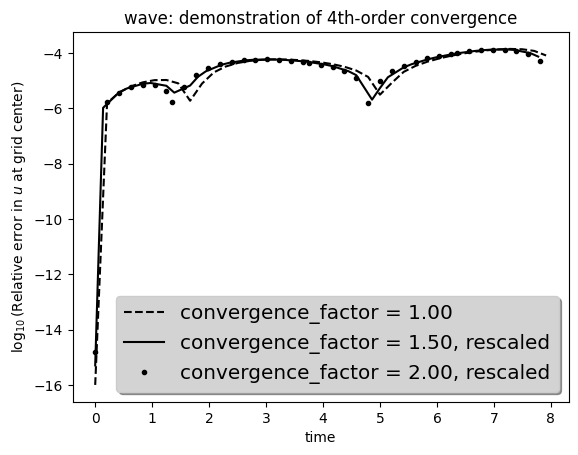

In [7]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

%matplotlib inline

import matplotlib as mpl
# Double check to ensure it stays quiet
mpl.set_loglevel("warning") 

import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename, col_time=0, col_error=1):
    """
    Read two columns (time and relative error) from a whitespace-separated file.
    """
    with open(filename) as f:
        reader = csv.reader(f, delimiter=" ")
        rows = []
        for row in reader:
            row = [tok for tok in row if tok != ""]
            if len(row) == 0:
                continue
            rows.append(row)
        data = list(zip(*rows))
        times = [float(val) for val in data[col_time]]
        errs = [float(val) for val in data[col_error]]
        return times, errs

# Paths to 0D output files
# Note: Ensure 'project_dir' is defined in a previous cell, 
# or define it here, e.g., project_dir = "."
f_coarse = os.path.join(project_dir, "out0d-conv_factor1.00.txt")
f_med    = os.path.join(project_dir, "out0d-conv_factor1.50.txt")
f_fine   = os.path.join(project_dir, "out0d-conv_factor2.00.txt")

t_coarse, err_coarse_rel = file_reader(f_coarse)
t_med,    err_med_rel    = file_reader(f_med)
t_fine,   err_fine_rel   = file_reader(f_fine)

# Convert to log10(error) with a small floor to avoid log10(0)
err_coarse = [mp.log10(e + 1e-16) for e in err_coarse_rel]
err_med    = [mp.log10(e + 1e-16) for e in err_med_rel]
err_fine   = [mp.log10(e + 1e-16) for e in err_fine_rel]

# Convergence factors c (relative to coarse run)
c_med  = 1.5
c_fine = 2.0

# Rescale medium and fine runs:
# log10(error_rescaled) = log10(error_original) + 4 * log10(c)
err_med_rescaled  = [e + 4 * mp.log10(c_med)  for e in err_med]
err_fine_rescaled = [e + 4 * mp.log10(c_fine) for e in err_fine]

fig, ax = plt.subplots()

plt.title("wave: demonstration of 4th-order convergence")
plt.xlabel("time")
plt.ylabel(r"$\log_{10}$(Relative error in $u$ at grid center)")

ax.plot(t_coarse, err_coarse,         "k--", label=r"convergence_factor = 1.00")
ax.plot(t_med,    err_med_rescaled,   "k-",  label=r"convergence_factor = 1.50, rescaled")
ax.plot(t_fine,   err_fine_rescaled, "k.",  label=r"convergence_factor = 2.00, rescaled")

legend = ax.legend(loc="lower right", shadow=True, fontsize="x-large")
legend.get_frame().set_facecolor("lightgray")
plt.show()